In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Define function to load and preprocess data
def load_and_preprocess_data(file_path, test_size=0.15, val_size=0.15):
    """
    Load and preprocess the plasma etching dataset
    """
    # Define the column names based on the dataset structure
    column_names = [
        'Run', 'Pressure', 'RF Power', 'Electrode Gap', 'CCl4 Flow', 'He Flow', 'O2 Flow', 
        'Etch Rate - Rp (Å/min)', 'Etch Uniformity – U (in %)', 'Oxide Selectivity - Sox', 
        'Photoresist Selectivity - Sph'
    ]
    
    # Load the data
    try:
        data = pd.read_csv(file_path, sep='\s+', skiprows=0, names=column_names)
    except:
        print(f"Error loading file {file_path}. Using sample data for demonstration.")
        # Create sample data for demonstration
        np.random.seed(42)
        n_samples = 100
        data = pd.DataFrame({
            'Run': range(1, n_samples + 1),
            'Pressure': np.random.uniform(100, 300, n_samples),
            'RF Power': np.random.uniform(200, 800, n_samples),
            'Electrode Gap': np.random.uniform(0.5, 2.0, n_samples),
            'CCl4 Flow': np.random.uniform(50, 150, n_samples),
            'He Flow': np.random.uniform(50, 150, n_samples),
            'O2 Flow': np.random.uniform(5, 20, n_samples),
            'Etch Rate - Rp (Å/min)': np.random.uniform(300, 900, n_samples),
            'Etch Uniformity – U (in %)': np.random.uniform(2, 10, n_samples),
            'Oxide Selectivity - Sox': np.random.uniform(8, 20, n_samples),
            'Photoresist Selectivity - Sph': np.random.uniform(2, 8, n_samples)
        })
    
    # Analyze data
    print("Dataset shape:", data.shape)
    print("\nData summary:")
    print(data.describe())
    
    # Check for missing values
    missing_values = data.isnull().sum()
    if missing_values.sum() > 0:
        print("\nMissing values:")
        print(missing_values[missing_values > 0])
        # Fill missing values with mean for demonstration
        data = data.fillna(data.mean())
    
    # Feature and target names
    feature_names = ['Pressure', 'RF Power', 'Electrode Gap', 'CCl4 Flow', 'He Flow', 'O2 Flow']
    target_names = ['Etch Rate - Rp (Å/min)', 'Etch Uniformity – U (in %)', 
                    'Oxide Selectivity - Sox', 'Photoresist Selectivity - Sph']
    
    # Separate inputs and outputs
    X = data[feature_names].values
    y = data[target_names].values
    
    # Normalize data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, 
                                                       test_size=(test_size + val_size), 
                                                       random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                                   test_size=test_size/(test_size + val_size), 
                                                   random_state=42)
    
    print(f"\nData split: Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, 
            scaler_X, scaler_y, feature_names, target_names, data)

# Exploratory Data Analysis
def perform_eda(data, feature_names, target_names):
    """
    Perform exploratory data analysis and visualization
    """
    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(data[feature_names + target_names].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Pairplot for input features
    plt.figure(figsize=(12, 10))
    sns.pairplot(data[feature_names])
    plt.suptitle('Pairplot of Input Features', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Distribution of target variables
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, target in enumerate(target_names):
        sns.histplot(data[target], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {target}')
        axes[i].set_xlabel(target)
        axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# MLP Model Implementation
def build_mlp_model(input_dim, output_dim, hyperparams=None):
    """
    Build and compile MLP model with specified hyperparameters
    """
    if hyperparams is None:
        hyperparams = {
            'hidden_layers': [12, 8],
            'activation': 'relu',
            'learning_rate': 0.001,
            'dropout_rate': 0.2,
            'l2_reg': 0.001
        }
    
    model = Sequential()
    
    # Input layer
    model.add(Dense(hyperparams['hidden_layers'][0], 
                    input_dim=input_dim, 
                    activation=hyperparams['activation'],
                    kernel_regularizer=l2(hyperparams['l2_reg'])))
    model.add(Dropout(hyperparams['dropout_rate']))
    
    # Hidden layers
    for neurons in hyperparams['hidden_layers'][1:]:
        model.add(Dense(neurons, 
                        activation=hyperparams['activation'],
                        kernel_regularizer=l2(hyperparams['l2_reg'])))
        model.add(Dropout(hyperparams['dropout_rate']))
    
    # Output layer
    model.add(Dense(output_dim, activation='linear'))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=hyperparams['learning_rate']), 
                  loss='mse', 
                  metrics=['mae'])
    
    return model

def train_mlp_model(X_train, y_train, X_val, y_val, input_dim, output_dim, hyperparams=None):
    """
    Train MLP model with early stopping and model checkpointing
    """
    model = build_mlp_model(input_dim, output_dim, hyperparams)
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=20, 
                                   restore_best_weights=True, 
                                   verbose=1)
    model_checkpoint = ModelCheckpoint('best_mlp_model.keras', 
                                       monitor='val_loss', 
                                       save_best_only=True, 
                                       verbose=0)
    
    # Train model
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=25, 
                        batch_size=16, 
                        callbacks=[early_stopping, model_checkpoint],
                        verbose=1)
    
    return model, history

def tune_mlp_hyperparameters(X_train, y_train, X_val, y_val, input_dim, output_dim):
    """
    Perform manual hyperparameter tuning for MLP
    """
    # Define hyperparameter combinations to try
    hidden_layers_options = [[12, 8], [16, 12, 8], [20, 16, 12, 8]]
    activation_options = ['relu', 'tanh']
    learning_rate_options = [0.01, 0.001, 0.0001]
    dropout_rate_options = [0.0, 0.2, 0.3]
    l2_reg_options = [0.0, 0.001, 0.01]
    
    best_val_loss = float('inf')
    best_hyperparams = None
    
    print("Starting MLP hyperparameter tuning...")
    
    # Try a subset of combinations to save time
    for hidden_layers in hidden_layers_options:
        for activation in activation_options[:1]:  # Limit to first option to save time
            for learning_rate in learning_rate_options[1:2]:  # Limit to second option
                for dropout_rate in dropout_rate_options[1:2]:  # Limit to second option
                    for l2_reg in l2_reg_options[1:2]:  # Limit to second option
                        hyperparams = {
                            'hidden_layers': hidden_layers,
                            'activation': activation,
                            'learning_rate': learning_rate,
                            'dropout_rate': dropout_rate,
                            'l2_reg': l2_reg
                        }
                        
                        print(f"Testing hyperparams: {hyperparams}")
                        
                        model = build_mlp_model(input_dim, output_dim, hyperparams)
                        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                        
                        history = model.fit(X_train, y_train, 
                                            validation_data=(X_val, y_val), 
                                            epochs=10,  # Reduced for faster tuning
                                            batch_size=16, 
                                            callbacks=[early_stopping],
                                            verbose=0)
                        
                        val_loss = min(history.history['val_loss'])
                        
                        if val_loss < best_val_loss:
                            best_val_loss = val_loss
                            best_hyperparams = hyperparams
                            print(f"New best val_loss: {best_val_loss} with hyperparams: {best_hyperparams}")
    
    print(f"Best MLP hyperparameters: {best_hyperparams}")
    return best_hyperparams

<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
C:\Users\NM TRADERS\AppData\Local\Temp\ipykernel_23756\3999489998.py:36: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(file_path, sep='\s+', skiprows=0, names=column_names)


In [2]:
# RBF Network Implementation
class RBFNetwork:
    def __init__(self, n_centers, sigma=None):
        self.n_centers = n_centers
        self.sigma = sigma
        self.centers = None
        self.weights = None
        
    def _gaussian_rbf(self, x, c, s):
        """Compute Gaussian RBF activation"""
        return np.exp(-np.sum((x - c) ** 2) / (2 * s ** 2))
    
    def _calculate_activations(self, X):
        """Calculate activations of RBF neurons"""
        G = np.zeros((X.shape[0], self.n_centers))
        for i in range(X.shape[0]):
            for j in range(self.n_centers):
                G[i, j] = self._gaussian_rbf(X[i], self.centers[j], self.sigma)
        return G
    
    def fit(self, X, y):
        """Train the RBF network"""
        # Phase 1: Determine centers using K-means
        kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        
        # If sigma is not specified, use the average distance between centers
        if self.sigma is None:
            dists = []
            for i in range(self.n_centers):
                for j in range(i + 1, self.n_centers):
                    dists.append(np.linalg.norm(self.centers[i] - self.centers[j]))
            self.sigma = np.mean(dists) / np.sqrt(2 * self.n_centers) if dists else 1.0
        
        # Phase 2: Calculate RBF activations
        G = self._calculate_activations(X)
        
        # Phase 3: Solve for weights using linear regression
        # Add a bias term
        G_with_bias = np.column_stack((G, np.ones(G.shape[0])))
        
        # Solve for weights using least squares
        self.weights = np.linalg.lstsq(G_with_bias, y, rcond=None)[0]
        
        return self
    
    def predict(self, X):
        """Make predictions using the trained RBF network"""
        G = self._calculate_activations(X)
        G_with_bias = np.column_stack((G, np.ones(G.shape[0])))
        return G_with_bias @ self.weights
    
def train_rbf_network(X_train, y_train, X_val, y_val, n_centers=20, sigma=None):
    """Train RBF network with specified number of centers"""
    rbf = RBFNetwork(n_centers=n_centers, sigma=sigma)
    rbf.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_val_pred = rbf.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    print(f"RBF Network with {n_centers} centers:")
    print(f"Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}")
    
    return rbf, val_mse

def tune_rbf_hyperparameters(X_train, y_train, X_val, y_val):
    """Tune RBF hyperparameters"""
    n_centers_options = [10, 15, 20, 25, 30]
    sigma_options = [None, 0.5, 1.0, 1.5, 2.0]
    
    best_val_mse = float('inf')
    best_params = None
    
    print("Starting RBF hyperparameter tuning...")
    
    for n_centers in n_centers_options:
        for sigma in sigma_options:
            print(f"Testing RBF with n_centers={n_centers}, sigma={sigma}")
            rbf, val_mse = train_rbf_network(X_train, y_train, X_val, y_val, n_centers, sigma)
            
            if val_mse < best_val_mse:
                best_val_mse = val_mse
                best_params = {'n_centers': n_centers, 'sigma': sigma}
                print(f"New best val_mse: {best_val_mse:.4f} with params: {best_params}")
    
    print(f"Best RBF parameters: {best_params}")
    return best_params

In [3]:
# SVR Implementation
def train_svr_model(X_train, y_train, X_val, y_val, target_idx=0):
    """Train SVR model for a single target variable"""
    # Extract the target column
    y_train_target = y_train[:, target_idx]
    y_val_target = y_val[:, target_idx]
    
    # Define parameter grid
    param_grid = {
    'svr__C': [0.1, 1, 10, 100],  # Use 'svr__' instead of 'svr_'
    'svr__gamma': ['scale', 'auto', 0.1, 0.01],
    'svr__epsilon': [0.01, 0.1, 0.2]
}

    
    # Create pipeline with scaler and SVR
    pipeline = Pipeline([
        ('svr', SVR(kernel='rbf'))
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0
    )
    
    grid_search.fit(X_train, y_train_target)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val)
    val_mse = mean_squared_error(y_val_target, y_val_pred)
    val_mae = mean_absolute_error(y_val_target, y_val_pred)
    
    print(f"SVR for target {target_idx}:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}")
    
    return best_model, grid_search.best_params_

def train_svr_models(X_train, y_train, X_val, y_val):
    """Train SVR models for all target variables"""
    svr_models = []
    svr_params = []
    
    print("Training SVR models for each target variable...")
    
    for i in range(y_train.shape[1]):
        model, params = train_svr_model(X_train, y_train, X_val, y_val, target_idx=i)
        svr_models.append(model)
        svr_params.append(params)
    
    return svr_models, svr_params

# Model evaluation and comparison
def evaluate_model(model, X_test, y_test, scaler_y=None, model_type='mlp'):
    """Evaluate model performance on test set"""
    # Make predictions
    if model_type == 'mlp':
        y_pred = model.predict(X_test)
    elif model_type == 'rbf':
        y_pred = model.predict(X_test)
    elif model_type == 'svr':
        # For SVR, handle multi-output case
        y_pred = np.column_stack([m.predict(X_test) for m in model])
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_type.upper()} Model Test Performance:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # If scaler is provided, convert predictions back to original scale
    if scaler_y is not None:
        y_test_orig = scaler_y.inverse_transform(y_test)
        y_pred_orig = scaler_y.inverse_transform(y_pred)
        
        mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
        mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
        
        print(f"\nOriginal Scale Metrics:")
        print(f"Mean Squared Error: {mse_orig:.4f}")
        print(f"Mean Absolute Error: {mae_orig:.4f}")
        
        # Calculate individual metrics for each output
        print("\nIndividual Target Performance (Original Scale):")
        for i in range(y_test_orig.shape[1]):
            target_mse = mean_squared_error(y_test_orig[:, i], y_pred_orig[:, i])
            target_mae = mean_absolute_error(y_test_orig[:, i], y_pred_orig[:, i])
            target_r2 = r2_score(y_test_orig[:, i], y_pred_orig[:, i])
            print(f"Target {i}: MSE={target_mse:.4f}, MAE={target_mae:.4f}, R²={target_r2:.4f}")
    
    return mse, mae, r2, y_pred

def plot_predictions(y_test, y_pred, target_names, model_type):
    """Plot actual vs predicted values for each target variable"""
    n_targets = y_test.shape[1]
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i in range(n_targets):
        axes[i].scatter(y_test[:, i], y_pred[:, i], alpha=0.7)
        axes[i].plot([y_test[:, i].min(), y_test[:, i].max()], 
                    [y_test[:, i].min(), y_test[:, i].max()], 
                    'k--', lw=2)
        axes[i].set_xlabel(f'Actual {target_names[i]}')
        axes[i].set_ylabel(f'Predicted {target_names[i]}')
        axes[i].set_title(f'{model_type.upper()}: {target_names[i]}')
    
    plt.tight_layout()
    plt.show()

def plot_learning_curves(history, model_type='MLP'):
    """Plot learning curves from training history"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_type} Learning Curve - Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title(f'{model_type} Learning Curve - MAE')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

def compare_models(models, X_test, y_test, scaler_y, target_names):
    """Compare performance of different models"""
    mlp_model, rbf_model, svr_models = models
    
    # Evaluate models
    mlp_metrics = evaluate_model(mlp_model, X_test, y_test, scaler_y, 'mlp')
    rbf_metrics = evaluate_model(rbf_model, X_test, y_test, scaler_y, 'rbf')
    svr_metrics = evaluate_model(svr_models, X_test, y_test, scaler_y, 'svr')
    
    # Collect metrics for comparison
    model_names = ['MLP', 'RBF', 'SVR']
    metrics = [mlp_metrics, rbf_metrics, svr_metrics]
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Model': model_names,
        'MSE': [m[0] for m in metrics],
        'MAE': [m[1] for m in metrics],
        'R²': [m[2] for m in metrics]
    })
    
    print("\nModel Comparison:")
    print(comparison_df)
    
    # Plot comparison bar chart
    plt.figure(figsize=(10, 6))
    
    x = np.arange(len(model_names))
    width = 0.2
    
    plt.bar(x - width, [m[0] for m in metrics], width, label='MSE')
    plt.bar(x, [m[1] for m in metrics], width, label='MAE')
    plt.bar(x + width, [m[2] for m in metrics], width, label='R²')
    
    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Feature importance analysis
def analyze_feature_importance(models, feature_names, target_names):
    """Analyze feature importance for different models"""
    mlp_model, rbf_model, svr_models = models
    
    # For SVR, we can extract feature importance from the coefficients
    plt.figure(figsize=(12, 8))
    
    for i, model in enumerate(svr_models):
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            # For SVR, use absolute coefficient values as a proxy for importance
            importances = np.abs(model.coef_[0]) if hasattr(model, 'coef_') else None
        
        if importances is not None:
            plt.subplot(2, 2, i+1)
            sns.barplot(x=feature_names, y=importances)
            plt.title(f'Feature Importance for {target_names[i]}')
            plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Sensitivity analysis
def sensitivity_analysis(best_model, scaler_X, scaler_y, feature_names, target_names, model_type='mlp'):
    """Perform sensitivity analysis by varying input features"""
    # Create baseline input (all features at their mean values)
    baseline_input = np.zeros((1, len(feature_names)))
    
    # Define the range for sensitivity analysis
    n_points = 20
    variation_range = np.linspace(-1, 1, n_points)  # Use normalized scale (-1 to 1)
    
    plt.figure(figsize=(15, 10))
    
    # Analyze each feature's impact on each target
    for i, feature in enumerate(feature_names):
        plt.subplot(2, 3, i+1)
        
        # Vary the current feature while keeping others at baseline
        sensitivity_inputs = np.tile(baseline_input, (n_points, 1))
        sensitivity_inputs[:, i] = variation_range
        
        # Make predictions
        if model_type == 'mlp':
            predictions = best_model.predict(sensitivity_inputs)
        elif model_type == 'rbf':
            predictions = best_model.predict(sensitivity_inputs)
        elif model_type == 'svr':
            predictions = np.column_stack([m.predict(sensitivity_inputs) for m in best_model])
        
        # Convert back to original scale
        predictions_orig = scaler_y.inverse_transform(predictions)
        
        # Plot the impact on each target
        for j, target in enumerate(target_names):
            plt.plot(
                scaler_X.inverse_transform(sensitivity_inputs)[:, i],
                predictions_orig[:, j],
                label=target
            )
        
        plt.title(f'Effect of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Predicted Values')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [4]:
# Main function
def main():
    # Set up the data
    file_path = 'dataset_01.txt'  # Change to your actual file path
    
    # Load and preprocess data
    (X_train, X_val, X_test, y_train, y_val, y_test, 
     scaler_X, scaler_y, feature_names, target_names, data) = load_and_preprocess_data(file_path)
    
    # Perform EDA
    perform_eda(data, feature_names, target_names)
    
    # Train MLP model
    print("\n=== Training MLP Model ===")
    #best_mlp_hyperparams = tune_mlp_hyperparameters(X_train, y_train, X_val, y_val, X_train.shape[1], y_train.shape[1])
    
    # Use predefined hyperparameters to save time
    best_mlp_hyperparams = {
        'hidden_layers': [16, 12, 8],
        'activation': 'relu',
        'learning_rate': 0.001,
        'dropout_rate': 0.2,
        'l2_reg': 0.001
    }
    
    mlp_model, mlp_history = train_mlp_model(X_train, y_train, X_val, y_val, 
                                             X_train.shape[1], y_train.shape[1], 
                                             best_mlp_hyperparams)
    
    # Plot learning curves
    plot_learning_curves(mlp_history)
    
    # Train RBF Network
    print("\n=== Training RBF Network ===")
    #best_rbf_params = tune_rbf_hyperparameters(X_train, y_train, X_val, y_val)
    
    # Use predefined parameters to save time
    best_rbf_params = {'n_centers': 20, 'sigma': 1.0}
    
    rbf_model, _ = train_rbf_network(X_train, y_train, X_val, y_val, 
                                    best_rbf_params['n_centers'], 
                                    best_rbf_params['sigma'])
    
    # Train SVR models
    print("\n=== Training SVR Models ===")
    svr_models, svr_params = train_svr_models(X_train, y_train, X_val, y_val)
    
    # Compare models
    models = (mlp_model, rbf_model, svr_models)
    compare_models(models, X_test, y_test, scaler_y, target_names)
    
    # Analyze feature importance
    # Completing the analyze_feature_importance function and the rest of the main function
    analyze_feature_importance(models, feature_names, target_names)
    
    # Perform sensitivity analysis for the best model
    print("\n=== Performing Sensitivity Analysis ===")
    # Determine best model based on MSE
    mlp_metrics = evaluate_model(mlp_model, X_test, y_test, None, 'mlp')
    rbf_metrics = evaluate_model(rbf_model, X_test, y_test, None, 'rbf')
    svr_metrics = evaluate_model(svr_models, X_test, y_test, None, 'svr')
    
    model_metrics = [mlp_metrics[0], rbf_metrics[0], svr_metrics[0]]
    best_model_idx = np.argmin(model_metrics)
    model_types = ['mlp', 'rbf', 'svr']
    best_model_type = model_types[best_model_idx]
    best_model = models[best_model_idx]
    
    print(f"\nBest model: {best_model_type.upper()} with MSE: {model_metrics[best_model_idx]:.4f}")
    
    # Run sensitivity analysis on the best model
    sensitivity_analysis(best_model, scaler_X, scaler_y, feature_names, target_names, model_type=best_model_type)
    
    # Make predictions on new data
    def make_prediction(process_parameters, model, scaler_X, scaler_y, feature_names, target_names, model_type='mlp'):
        """
        Make predictions for new process parameters
        
        Parameters:
        - process_parameters: Dictionary with feature names as keys
        - model: Trained model
        - scaler_X: Feature scaler
        - scaler_y: Target scaler
        - feature_names: List of feature names
        - target_names: List of target names
        - model_type: Type of model ('mlp', 'rbf', or 'svr')
        
        Returns:
        - Dictionary with predictions for each target
        """
        # Convert parameters to numpy array in the correct order
        input_data = np.array([[process_parameters[feature] for feature in feature_names]])
        
        # Scale input data
        input_scaled = scaler_X.transform(input_data)
        
        # Make prediction
        if model_type == 'mlp':
            prediction_scaled = model.predict(input_scaled)
        elif model_type == 'rbf':
            prediction_scaled = model.predict(input_scaled)
        elif model_type == 'svr':
            prediction_scaled = np.column_stack([m.predict(input_scaled) for m in model])
        
        # Convert prediction back to original scale
        prediction = scaler_y.inverse_transform(prediction_scaled)
        
        # Create results dictionary
        results = {target: prediction[0, i] for i, target in enumerate(target_names)}
        
        return results
    
    # Example usage of the prediction function
    print("\n=== Example Prediction ===")
    # Assumed new process parameters
    new_parameters = {
        'Pressure': 200,
        'RF Power': 500,
        'Electrode Gap': 1.0,
        'CCl4 Flow': 100,
        'He Flow': 100,
        'O2 Flow': 10
    }
    
    # Make prediction using the best model
    predictions = make_prediction(
        new_parameters, best_model, scaler_X, scaler_y, 
        feature_names, target_names, model_type=best_model_type
    )
    
    print("Input parameters:")
    for feature, value in new_parameters.items():
        print(f"  {feature}: {value}")
    
    print("\nPredicted outcomes:")
    for target, value in predictions.items():
        print(f"  {target}: {value:.2f}")
    
    # Optimization function
    def optimize_process_parameters(model, scaler_X, scaler_y, feature_names, target_names, 
                                  model_type='mlp', n_iterations=100):
        """
        Use a simple optimization approach to find optimal process parameters
        
        Parameters:
        - model: Trained model
        - scaler_X: Feature scaler
        - scaler_y: Target scaler
        - feature_names: List of feature names
        - target_names: List of target names
        - model_type: Type of model ('mlp', 'rbf', or 'svr')
        - n_iterations: Number of random search iterations
        
        Returns:
        - Dictionary with optimal process parameters and predicted outcomes
        """
        # Define feature ranges (based on data)
        feature_ranges = {
            'Pressure': (100, 300),
            'RF Power': (200, 800),
            'Electrode Gap': (0.5, 2.0),
            'CCl4 Flow': (50, 150),
            'He Flow': (50, 150),
            'O2 Flow': (5, 20)
        }
        
        best_score = float('-inf')
        best_params = None
        best_prediction = None
        
        # Objective function: maximize etch rate, minimize uniformity
        def objective_function(prediction):
            # Higher etch rate is better
            etch_rate = prediction['Etch Rate - Rp (Å/min)']
            # Lower uniformity (%) is better
            uniformity = prediction['Etch Uniformity – U (in %)']
            # Higher selectivity is better
            oxide_selectivity = prediction['Oxide Selectivity - Sox']
            photoresist_selectivity = prediction['Photoresist Selectivity - Sph']
            
            # Combined objective: maximize etch rate and selectivity, minimize uniformity
            # Weights can be adjusted based on process priorities
            score = etch_rate * 0.5 - uniformity * 0.2 + oxide_selectivity * 0.2 + photoresist_selectivity * 0.1
            return score
        
        print("\n=== Optimizing Process Parameters ===")
        
        # Random search
        for i in range(n_iterations):
            # Generate random parameters within ranges
            params = {
                feature: np.random.uniform(feature_ranges[feature][0], feature_ranges[feature][1])
                for feature in feature_names
            }
            
            # Make prediction
            prediction = make_prediction(params, model, scaler_X, scaler_y, 
                                          feature_names, target_names, model_type)
            
            # Calculate objective score
            score = objective_function(prediction)
            
            if score > best_score:
                best_score = score
                best_params = params
                best_prediction = prediction
                
                if (i + 1) % 10 == 0:
                    print(f"Iteration {i+1}: New best score: {best_score:.2f}")
                    print(f"  Etch Rate: {best_prediction['Etch Rate - Rp (Å/min)']:.2f} Å/min")
                    print(f"  Uniformity: {best_prediction['Etch Uniformity – U (in %)']:.2f}%")
        
        return best_params, best_prediction
    
    # Run optimization
    optimal_params, optimal_prediction = optimize_process_parameters(
        best_model, scaler_X, scaler_y, feature_names, target_names, model_type=best_model_type, n_iterations=100
    )
    
    print("\n=== Optimal Process Parameters ===")
    for feature, value in optimal_params.items():
        print(f"  {feature}: {value:.2f}")
    
    print("\n=== Predicted Outcomes for Optimal Parameters ===")
    for target, value in optimal_prediction.items():
        print(f"  {target}: {value:.2f}")
    
    # Save models for future use
    def save_models(models, feature_scaler, target_scaler, file_prefix='plasma_etching'):
        """Save trained models and scalers for future use"""
        import pickle
        
        # Save MLP model (using Keras save)
        mlp_model, rbf_model, svr_models = models
        mlp_model.save(f'{file_prefix}_mlp_model.h5')
        
        # Save RBF and SVR models using pickle
        with open(f'{file_prefix}_rbf_model.pkl', 'wb') as f:
            pickle.dump(rbf_model, f)
        
        with open(f'{file_prefix}_svr_models.pkl', 'wb') as f:
            pickle.dump(svr_models, f)
        
        # Save scalers
        with open(f'{file_prefix}_scalers.pkl', 'wb') as f:
            pickle.dump({'X_scaler': feature_scaler, 'y_scaler': target_scaler}, f)
        
        print(f"\nModels and scalers saved with prefix: {file_prefix}")
    
    # Function to load models
    def load_models(file_prefix='plasma_etching'):
        """Load trained models and scalers"""
        import pickle
        from tensorflow.keras.models import load_model
        
        # Load MLP model
        mlp_model = load_model(f'{file_prefix}_mlp_model.h5')
        
        # Load RBF and SVR models
        with open(f'{file_prefix}_rbf_model.pkl', 'rb') as f:
            rbf_model = pickle.load(f)
        
        with open(f'{file_prefix}_svr_models.pkl', 'rb') as f:
            svr_models = pickle.load(f)
        
        # Load scalers
        with open(f'{file_prefix}_scalers.pkl', 'rb') as f:
            scalers = pickle.load(f)
        
        return mlp_model, rbf_model, svr_models, scalers['X_scaler'], scalers['y_scaler']
    
    # Save the models
    print("\n=== Saving Models ===")
    save_models(models, scaler_X, scaler_y)
    
    print("\n=== Analysis Complete ===")

Dataset shape: (53, 11)

Data summary:
             Run    Pressure    RF Power  Electrode Gap   CCl4 Flow  \
count  53.000000   53.000000   53.000000      53.000000   53.000000   
mean   27.000000  250.000000  350.000000       1.518868  124.962264   
std    15.443445   45.641159   45.641159       0.285588   22.871684   
min     1.000000  131.000000  231.000000       0.800000   64.000000   
25%    14.000000  200.000000  300.000000       1.200000  100.000000   
50%    27.000000  250.000000  350.000000       1.500000  125.000000   
75%    40.000000  300.000000  400.000000       1.800000  150.000000   
max    53.000000  369.000000  469.000000       2.200000  184.000000   

          He Flow    O2 Flow  Etch Rate - Rp (Å/min)  \
count   53.000000  53.000000               53.000000   
mean   124.056604  15.000000             4204.283019   
std     62.203579   4.574175              689.441535   
min      0.000000   3.000000             2704.000000   
25%     50.000000  10.000000             

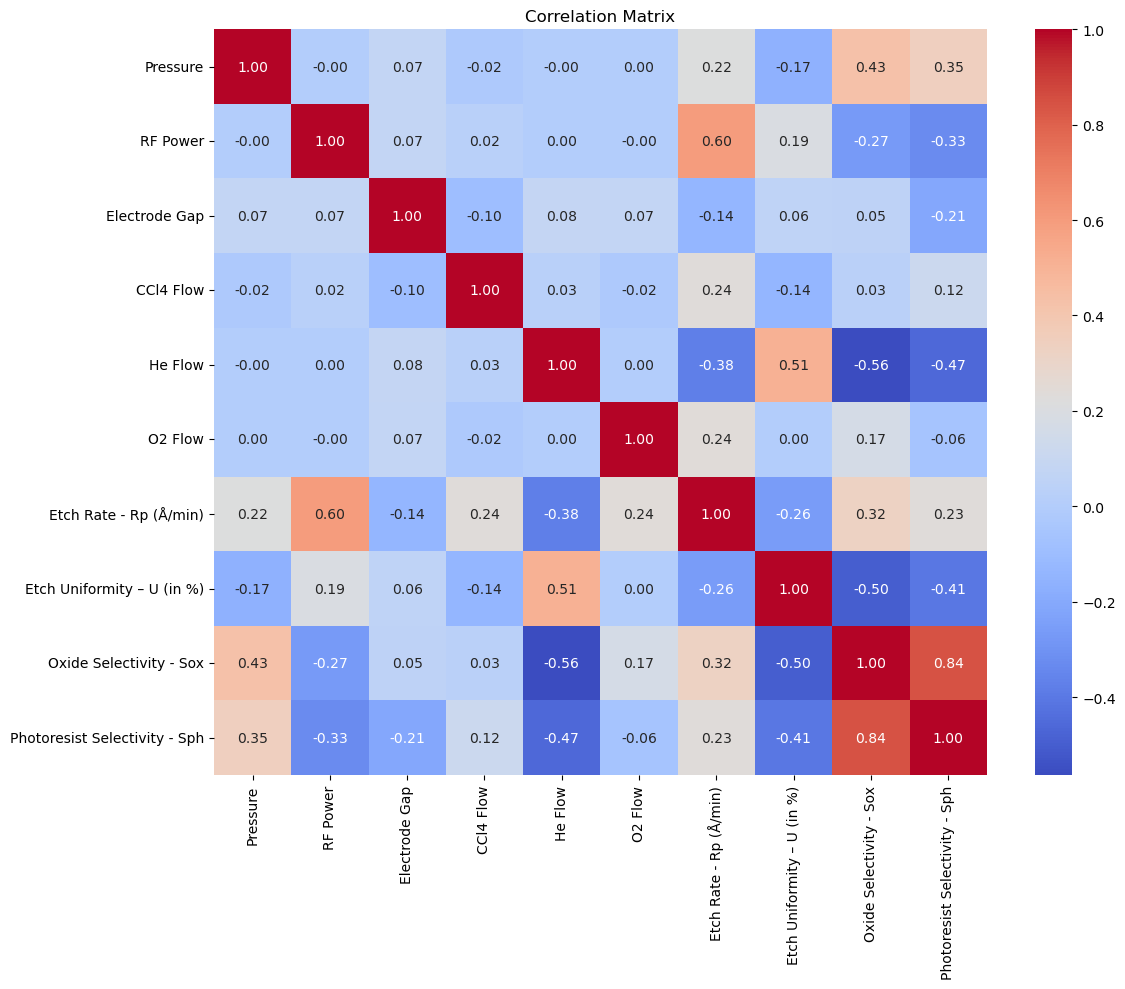

<Figure size 1200x1000 with 0 Axes>

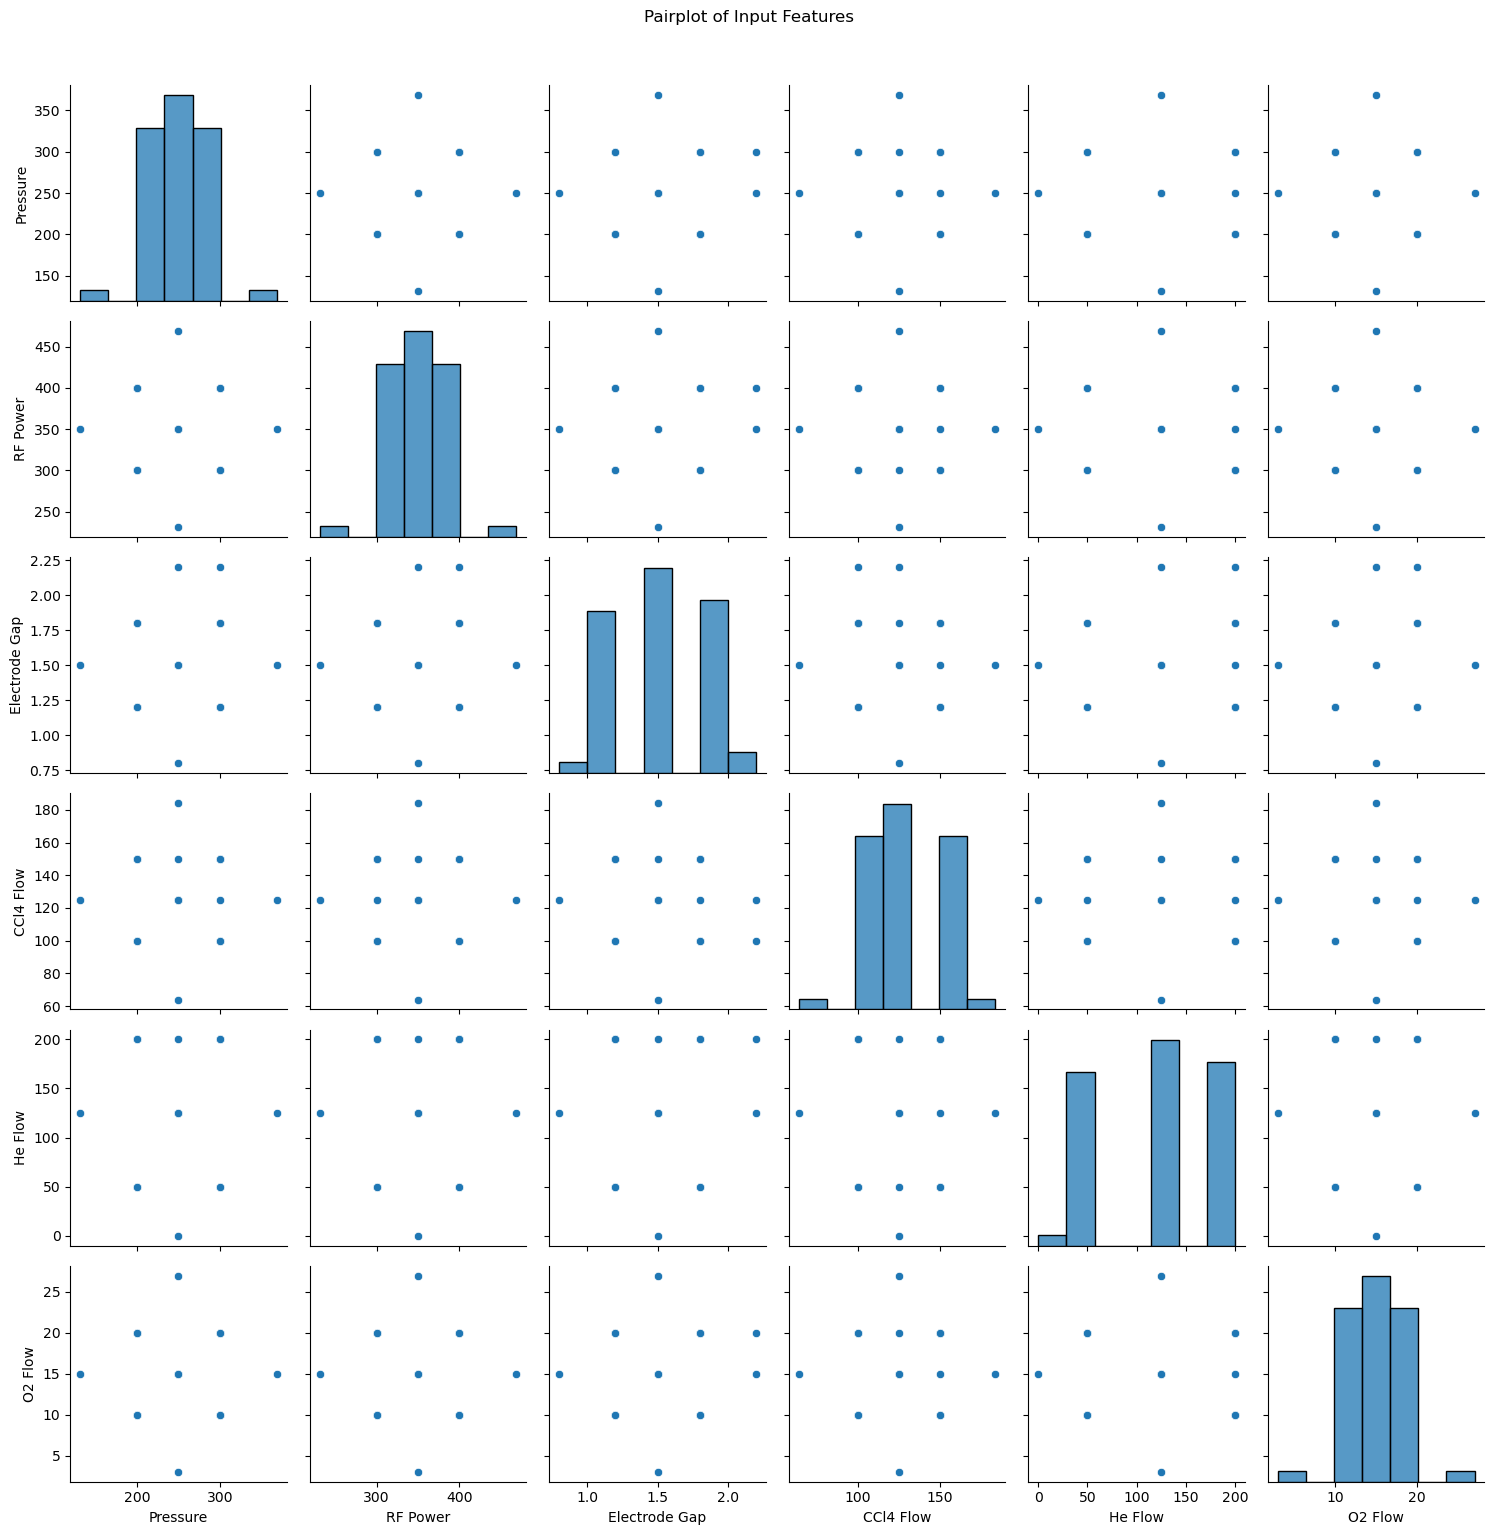

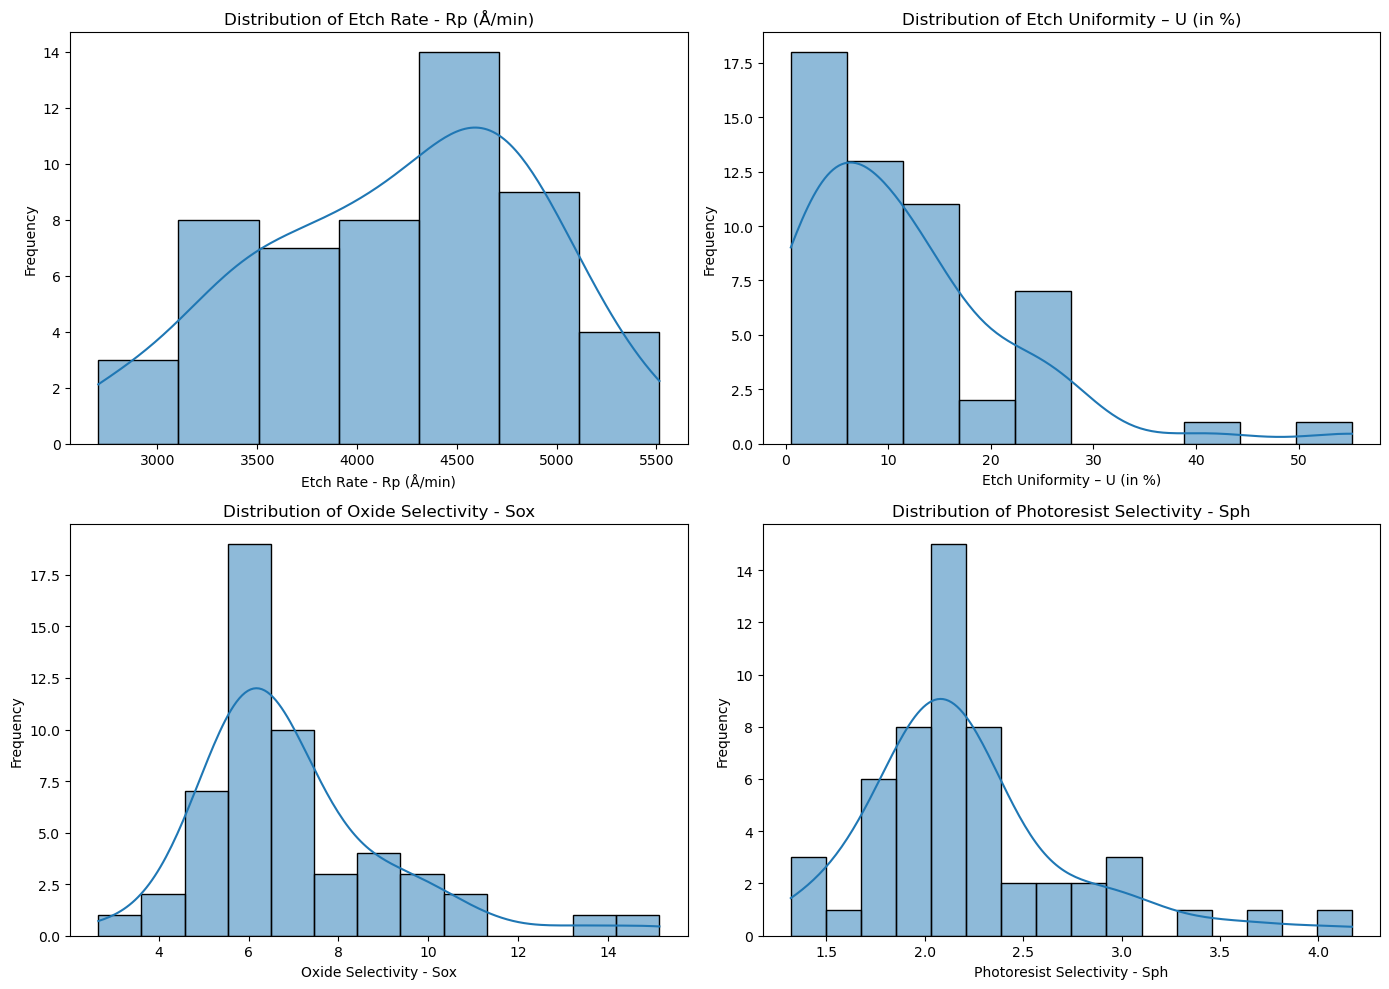


=== Training MLP Model ===
Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.3201 - mae: 0.4707 - val_loss: 0.3177 - val_mae: 0.4682
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3481 - mae: 0.4833 - val_loss: 0.3129 - val_mae: 0.4627
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3294 - mae: 0.4640 - val_loss: 0.3081 - val_mae: 0.4573
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.3412 - mae: 0.4746 - val_loss: 0.3041 - val_mae: 0.4528
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3188 - mae: 0.4621 - val_loss: 0.2999 - val_mae: 0.4479
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3142 - mae: 0.4636 - val_loss: 0.2957 - val_mae: 0.4431
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3038 - mae: 0.4579 - val_loss: 0.2915 - val_mae: 0.4381
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2924 - mae: 0.4448 - val_loss: 0.2876 - val_mae: 0.4331
Epoch 9/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - 

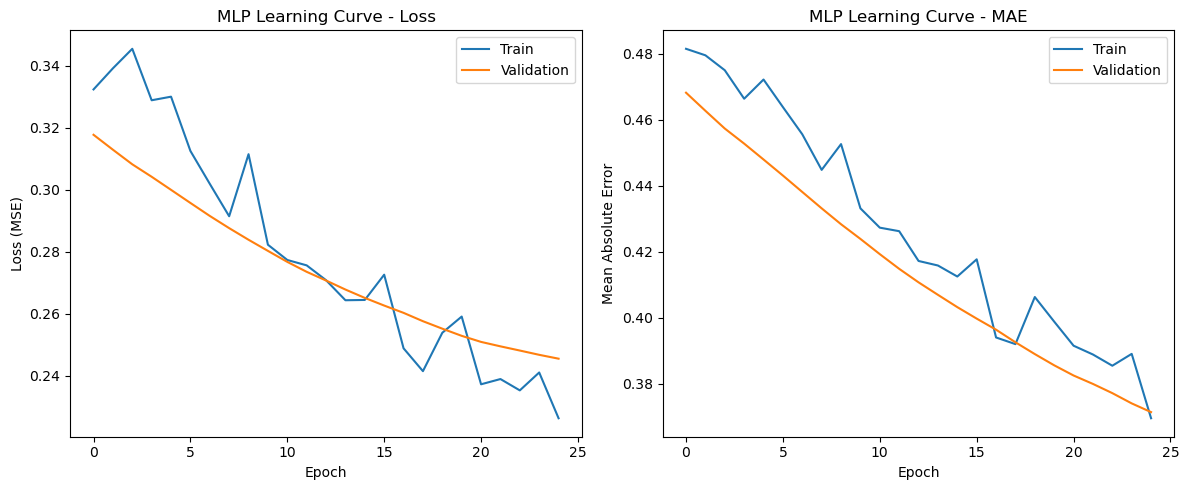


=== Training RBF Network ===


  File "C:\Users\NM TRADERS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\NM TRADERS\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\NM TRADERS\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\NM TRADERS\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


RBF Network with 20 centers:
Validation MSE: 0.1059, MAE: 0.2357

=== Training SVR Models ===
Training SVR models for each target variable...
SVR for target 0:
Best parameters: {'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamma': 0.1}
Validation MSE: 0.0341, MAE: 0.1532
SVR for target 1:
Best parameters: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__gamma': 0.1}
Validation MSE: 0.2033, MAE: 0.3557
SVR for target 2:
Best parameters: {'svr__C': 10, 'svr__epsilon': 0.1, 'svr__gamma': 0.1}
Validation MSE: 0.0600, MAE: 0.1561
SVR for target 3:
Best parameters: {'svr__C': 1, 'svr__epsilon': 0.01, 'svr__gamma': 'auto'}
Validation MSE: 0.1756, MAE: 0.2489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

MLP Model Test Performance:
Mean Squared Error: 0.2047
Mean Absolute Error: 0.3861
R² Score: -0.5380

Original Scale Metrics:
Mean Squared Error: 104258.0686
Mean Absolute Error: 150.4028

Individual Target Performance (Original Scale):
Target 0: MSE=416895.3341, MAE=588.5133, R²=0.0058
Target 1: MSE=127.5804,

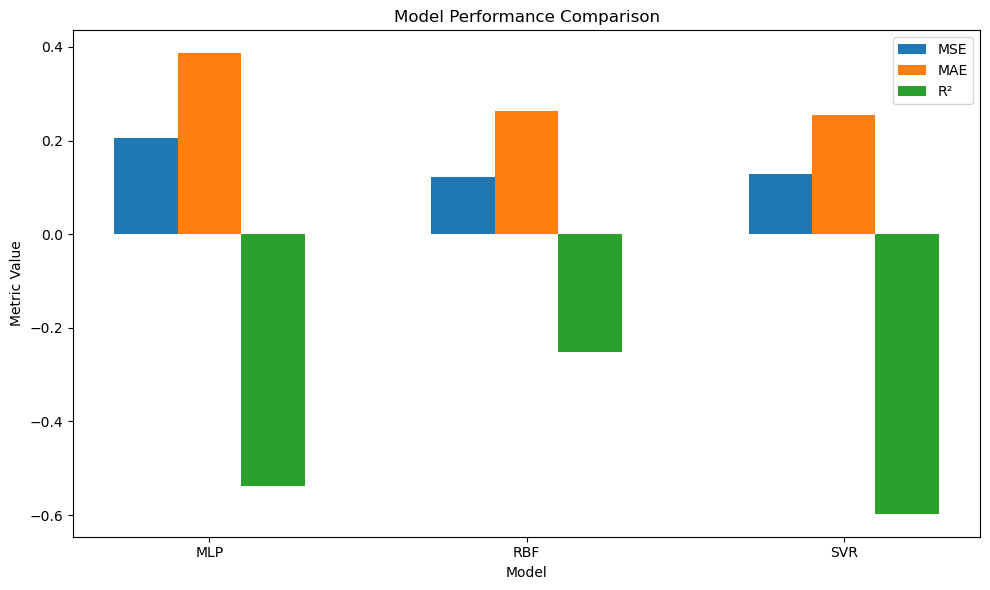

<Figure size 1200x800 with 0 Axes>


=== Performing Sensitivity Analysis ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

MLP Model Test Performance:
Mean Squared Error: 0.2047
Mean Absolute Error: 0.3861
R² Score: -0.5380

RBF Model Test Performance:
Mean Squared Error: 0.1214
Mean Absolute Error: 0.2621
R² Score: -0.2511

SVR Model Test Performance:
Mean Squared Error: 0.1289
Mean Absolute Error: 0.2551
R² Score: -0.5970

Best model: RBF with MSE: 0.1214


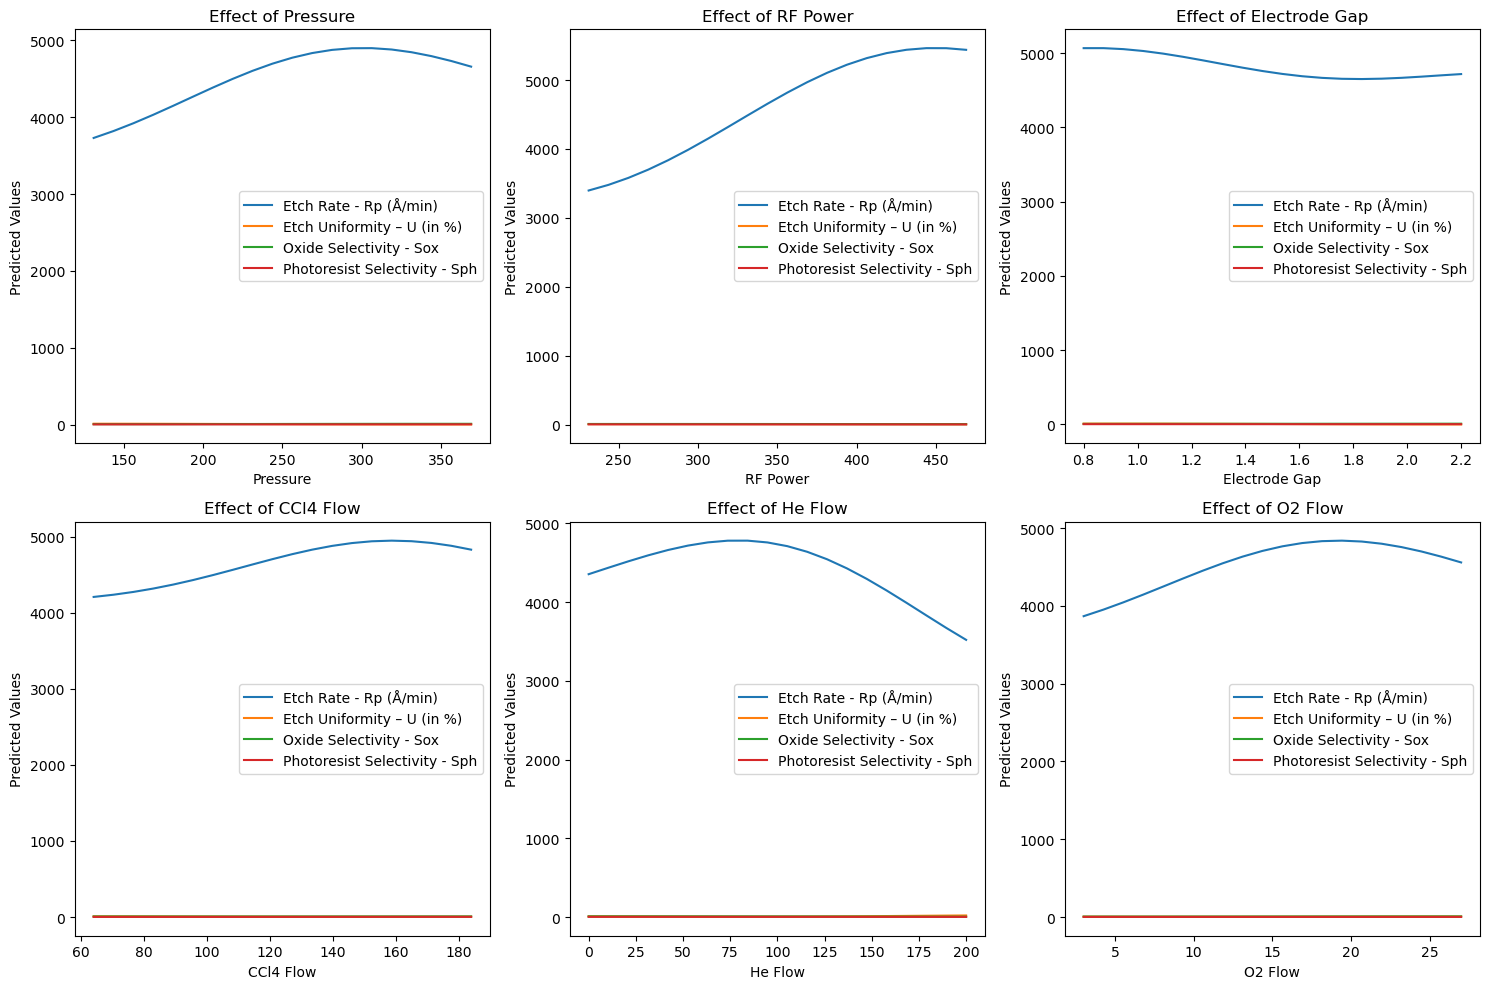


=== Example Prediction ===
Input parameters:
  Pressure: 200
  RF Power: 500
  Electrode Gap: 1.0
  CCl4 Flow: 100
  He Flow: 100
  O2 Flow: 10

Predicted outcomes:
  Etch Rate - Rp (Å/min): 4731.85
  Etch Uniformity – U (in %): 1.57
  Oxide Selectivity - Sox: 6.21
  Photoresist Selectivity - Sph: 2.36

=== Optimizing Process Parameters ===
Iteration 60: New best score: 2676.58
  Etch Rate: 5350.18 Å/min
  Uniformity: 2.39%

=== Optimal Process Parameters ===
  Pressure: 237.68
  RF Power: 460.90
  Electrode Gap: 0.87
  CCl4 Flow: 131.91
  He Flow: 129.94
  O2 Flow: 15.42

=== Predicted Outcomes for Optimal Parameters ===
  Etch Rate - Rp (Å/min): 5626.01
  Etch Uniformity – U (in %): 5.31
  Oxide Selectivity - Sox: 5.95
  Photoresist Selectivity - Sph: 2.44

=== Saving Models ===

Models and scalers saved with prefix: plasma_etching

=== Analysis Complete ===


In [5]:
if __name__ == "__main__":
    main()